In [2]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver  # InMemorySaver is exactly same as MemorySaver in Day 10 code
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import TypedDict

In [3]:
load_dotenv()

True

In [4]:
llm = ChatOpenAI()

In [5]:
class JokeState(TypedDict):
    topic: str
    joke: str
    explanation: str

In [6]:
def generate_joke(state: JokeState):
    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content

    return {"joke": response}

In [7]:
def generate_explanation(state: JokeState):
    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content

    return {"explanation": response}

In [8]:
graph = StateGraph(JokeState)

graph.add_node("generate_joke", generate_joke)
graph.add_node("generate_explanation", generate_explanation)

graph.add_edge(START, "generate_joke")
graph.add_edge("generate_joke", "generate_explanation")
graph.add_edge("generate_explanation", END)

checkpointer = InMemorySaver()
workflow = graph.compile(checkpointer = checkpointer)

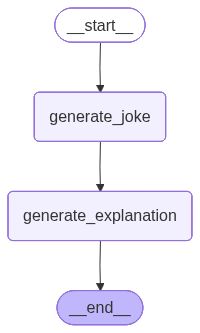

In [9]:
workflow

In [10]:
config1 = {"configurable": {"thread_id": "1"}}
initial_state = {"topic": "pizza"}
final_state = workflow.invoke(initial_state, config = config1)

In [11]:
final_state

{'topic': 'pizza',
 'joke': 'Why did the pizza go to the dentist?\nBecause it needed a little extra dough-cayre!',
 'explanation': 'This joke is a play on words, combining the idea of "dough" (the main ingredient in pizza) with "décor" (the items and furnishings that make a space attractive or comfortable). In this joke, the pizza went to the dentist because it needed "dough-cayre," which sounds like "décor" but actually means "dental care." The humor comes from the unexpected twist in the wordplay and the absurdity of a pizza needing dental care.'}

In [12]:
workflow.get_state(config = config1)
# What the output of the above line represents? -> It returns the latest saved state for thread 1. So, in our case, it returns the state after generate_explanation node got executed. Note that I did't say after the END node got executed because END is not an executable node. It’s a terminal marker in the graph. No function runs at END.
# Below is the description of each field we are seeing in the result:

# -----------------------------
# StateSnapshot Explanation
# -----------------------------
# A StateSnapshot is a checkpointed snapshot of the workflow execution
# at a specific moment in time. It represents the saved state of the graph.

# values:
#   The current state dictionary of the graph.
#   Contains all state variables and outputs produced so far -> matlab saved state mein apne JokeState schema ke saare fields ke values

# next:
#   The next node(s) to be executed.
#   If empty, the workflow has finished execution.

# config:
#   Runtime execution configuration for this checkpoint.
#   Identifies the thread, namespace, and unique checkpoint ID.

# metadata:
#   Internal execution metadata used for tracing and debugging.
#   Includes step number, execution source, and parent relationships.

# created_at:
#   Timestamp when this checkpoint was created.

# parent_config:
#   Configuration of the previous checkpoint.
#   Used to track execution history and support resume/replay.

# tasks:
#   Pending or scheduled background tasks.
#   Used for async, parallel, or tool-based execution.

# interrupts:
#   Paused execution points.
#   Used for human-in-the-loop or approval-based workflows.

# Mental Model:
#   Think of StateSnapshot like a Git commit for your workflow state.
#   It captures the full memory, execution pointer, and history chain.

StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the dentist?\nBecause it needed a little extra dough-cayre!', 'explanation': 'This joke is a play on words, combining the idea of "dough" (the main ingredient in pizza) with "décor" (the items and furnishings that make a space attractive or comfortable). In this joke, the pizza went to the dentist because it needed "dough-cayre," which sounds like "décor" but actually means "dental care." The humor comes from the unexpected twist in the wordplay and the absurdity of a pizza needing dental care.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee06-e71e-6aab-8002-5d8ed542f269'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-11T11:26:54.152977+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee06-d834-668b-8001-480b4fedf7cd'}}, tasks=(), interrupts=())

In [13]:
# Here's how we can get all the intermediate saved states too along with the latest saved state.
list(workflow.get_state_history(config = config1))
# Resultant list mein sabse last wala value sabse first state ko darsha raha hai jo START node execute hone ke pehle tha. THat's why abhi values() mein topic bhi nahi hai aur next mein START node hai representing that next doe to be executed is the START node.
# 2nd last wala value START node ka execution khatam hone ke just baad ka state hai. Here we have the topic 'pizza'
# 3rd last wala value generate_joke node ka execution khatam hone ke just baad ka state hai. Here we have the topic as well as the joke.
# And 4th last value is exactly same as the output of previous cell.


[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the dentist?\nBecause it needed a little extra dough-cayre!', 'explanation': 'This joke is a play on words, combining the idea of "dough" (the main ingredient in pizza) with "décor" (the items and furnishings that make a space attractive or comfortable). In this joke, the pizza went to the dentist because it needed "dough-cayre," which sounds like "décor" but actually means "dental care." The humor comes from the unexpected twist in the wordplay and the absurdity of a pizza needing dental care.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee06-e71e-6aab-8002-5d8ed542f269'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-11T11:26:54.152977+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee06-d834-668b-8001-480b4fedf7cd'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': '

In [14]:
# Let's make another theread
config2 = {"configurable": {"thread_id": "2"}}
workflow.invoke({"topic": "pasta"}, config = config2)

{'topic': 'pasta',
 'joke': 'Why did the pasta go to the party?\nBecause it was feeling saucy!',
 'explanation': 'This joke plays on the double meaning of the word "saucy." In one sense, "saucy" can mean cheeky or sassy, as if the pasta is feeling bold or mischievous. In another sense, "saucy" can refer to having sauce on it, as pasta often does. So when the pasta goes to the party because it\'s feeling "saucy," it can be interpreted as both wanting to have a good time and literally being covered in sauce.'}

In [15]:
workflow.get_state(config = config2)
# Now, iss thread ke liye alga se data save ho raha hai as you can see. THis thread is independent of thread 1.

StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the pasta go to the party?\nBecause it was feeling saucy!', 'explanation': 'This joke plays on the double meaning of the word "saucy." In one sense, "saucy" can mean cheeky or sassy, as if the pasta is feeling bold or mischievous. In another sense, "saucy" can refer to having sauce on it, as pasta often does. So when the pasta goes to the party because it\'s feeling "saucy," it can be interpreted as both wanting to have a good time and literally being covered in sauce.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee07-0776-607b-8002-388ac3598a7c'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-11T11:26:57.544204+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee06-f676-640d-8001-4b909b185c92'}}, tasks=(), interrupts=())

# Fault Tolerance

In [16]:
import time

In [17]:
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str

In [18]:
def step_1(state: CrashState) -> CrashState:
    print("Step 1 executed")
    return {"step1": "done", "input": state["input"]}

def step_2(state: CrashState) -> CrashState:
    print("Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
    time.sleep(20)
    return {"step2": "done"}

def step_3(state: CrashState) -> CrashState:
    print("Step 3 executed")
    return {"done": True}

In [19]:
graph = StateGraph(CrashState)

graph.add_node("step_1", step_1)
graph.add_node("step_2", step_2)
graph.add_node("step_3", step_3)

graph.add_edge(START, "step_1")
graph.add_edge("step_1", "step_2")
graph.add_edge("step_2", "step_3")
graph.add_edge("step_3", END)

checkpointer = InMemorySaver()
workflow = graph.compile(checkpointer = checkpointer)

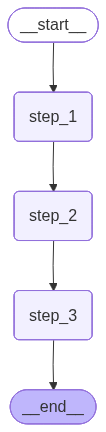

In [20]:
workflow

In [22]:
try:
    print("Running graph: Please manually interrupt during Step 2...")
    workflow.invoke({"input": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("Kernel manually interrupted (crash simulated).")

Running graph: Please manually interrupt during Step 2...
Step 1 executed
Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)
Kernel manually interrupted (crash simulated).


In [24]:
# So, step 2 execute nahi hua but step 1 ho chuka hai. AB hum apna workflow resume karenge.
final_state = workflow.invoke(None, config = {"configurable": {"thread_id": "thread-1"}})

Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)
Step 3 executed


In [ ]:
# Yeh 'None' se hum koi initial state provide nahi kar rahe hain. So, hum yeh bata rahe hain ki hume apna workflow resume karna hai and as we can see in the above output that step 1 execute nahi hua.

# Time Travel

In [26]:
# Iss feature mein hum workflow mein jitne steps execute ho gaye hain, unme se kisi bhi ek step se waapas continue kar sakte hain. Let's see how.

In [27]:
graph = StateGraph(JokeState)

graph.add_node("generate_joke", generate_joke)
graph.add_node("generate_explanation", generate_explanation)

graph.add_edge(START, "generate_joke")
graph.add_edge("generate_joke", "generate_explanation")
graph.add_edge("generate_explanation", END)

checkpointer = InMemorySaver()
workflow = graph.compile(checkpointer = checkpointer)

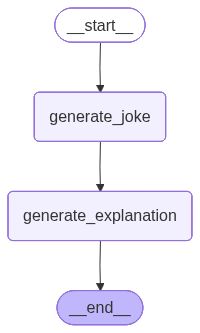

In [30]:
workflow

In [28]:
config1 = {"configurable": {"thread_id": "1"}}
initial_state = {"topic": "pizza"}
final_state = workflow.invoke(initial_state, config = config1)

In [29]:
final_state

{'topic': 'pizza',
 'joke': 'Why did the pizza maker go to therapy? Because he kneaded to work on his emotional crust!',
 'explanation': 'This joke plays on the pun using the word "knead" in two different contexts. In the culinary world, kneading refers to the process of working dough to develop gluten and create a smooth, elastic texture. In the joke, it is used humorously to suggest that the pizza maker needed to work on his emotional well-being, his "crust," so he went to therapy. This clever wordplay adds a humorous twist to the idea of seeking help for personal growth and self-improvement.'}

In [31]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza maker go to therapy? Because he kneaded to work on his emotional crust!', 'explanation': 'This joke plays on the pun using the word "knead" in two different contexts. In the culinary world, kneading refers to the process of working dough to develop gluten and create a smooth, elastic texture. In the joke, it is used humorously to suggest that the pizza maker needed to work on his emotional well-being, his "crust," so he went to therapy. This clever wordplay adds a humorous twist to the idea of seeking help for personal growth and self-improvement.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee4a-1df2-6f9f-8002-d8bba4e5a62f'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-11T11:56:58.419804+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee4a-0d1a-6659-8001-f5359e74a70a'}}, tasks=(), i

In [32]:
# Now, generate_explanation se waapas workflow run karte hain
# So, we have to give use checkpoint_id generated after the execution of 'generate_joke', i.e., '1f0eee4a-0d1a-6659-8001-f5359e74a70a'.
final_state = workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": "1f0eee4a-0d1a-6659-8001-f5359e74a70a"}})

In [ ]:
final_state
# As we can see in the output that joke is same as before but explanation is different.

{'topic': 'pizza',
 'joke': 'Why did the pizza maker go to therapy? Because he kneaded to work on his emotional crust!',
 'explanation': 'The joke plays on the homophones "kneaded" (the process of working dough) and "needed" (requiring something essential). In this context, the pizza maker went to therapy because he "kneaded" (physically worked on) his emotional "crust" (the base or foundation of his feelings or emotions). The pun adds a light-hearted twist to the idea of seeking therapy for personal issues, using wordplay related to making pizza.'}

In [ ]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza maker go to therapy? Because he kneaded to work on his emotional crust!', 'explanation': 'The joke plays on the homophones "kneaded" (the process of working dough) and "needed" (requiring something essential). In this context, the pizza maker went to therapy because he "kneaded" (physically worked on) his emotional "crust" (the base or foundation of his feelings or emotions). The pun adds a light-hearted twist to the idea of seeking therapy for personal issues, using wordplay related to making pizza.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee68-82ed-6f2b-8002-359ca22b45c8'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-11T12:10:34.314730+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee4a-0d1a-6659-8001-f5359e74a70a'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': '

In [35]:
# We can see here that pehle total snapshots 4 the but ab 5 ho gaye hain because "generate_explanation" node 2 times execute ho gaya, so ek additional snapshot aa gaya.
# Now, let's resume our workflow after start node execution. Kaayde se total snapshots ko 7 ho jaana chahiye because ab genreate_joke and generate_explanation ek baar aur execute honge.

In [36]:
final_state = workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": "1f0eee49-f61b-654b-8000-819a57d36cc6"}})

In [38]:
final_state
# As we can see, joke and explanation dono badal gaye.

{'topic': 'pizza',
 'joke': 'Why did the pizza go to the therapist? \nBecause it felt like it was being cheesed off too much!',
 'explanation': 'This joke plays on the pun of "cheesed off," which means to be annoyed or frustrated. The pizza went to the therapist because it felt like it was being cheesed off too much, implying that it was feeling overwhelmed by all the cheese being put on top of it. The humor comes from the unexpected idea of a pizza seeking therapy for feeling overwhelmed by cheese, turning a common expression into a playful and silly scenario.'}

In [39]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the therapist? \nBecause it felt like it was being cheesed off too much!', 'explanation': 'This joke plays on the pun of "cheesed off," which means to be annoyed or frustrated. The pizza went to the therapist because it felt like it was being cheesed off too much, implying that it was feeling overwhelmed by all the cheese being put on top of it. The humor comes from the unexpected idea of a pizza seeking therapy for feeling overwhelmed by cheese, turning a common expression into a playful and silly scenario.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee75-becb-6faa-8002-fb39047ff778'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-11T12:16:29.558365+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee75-b2e0-65ee-8001-cbfc91f46372'}}, tasks=(), interrupts=()),
 StateSnapshot(valu

In [40]:
# As expected, total snapshots = 7. First two snapshots in the above list are the new snapshots.

In [41]:
# We can also update any previously executed state and then resume the workflow from that point with the updated state. Here's how.

In [42]:
# Let's update the topic name to 'samosa'
# Toh iske liye hume woh checkpoint_id chahiye jisme topic ka naam update hua tha to 'pizza'
# Phir uss checkpoint se topic ka naam update kar denge to "samosa"
# So, we need checkpoint_id listed in the 2nd last element of the above list i.e., "1f0eee49-f61b-654b-8000-819a57d36cc6"
workflow.update_state(
    config = {'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee49-f61b-654b-8000-819a57d36cc6'}},
    values = {"topic": "samosa"}
    )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0eee9b-7bd6-62b5-8001-2bafce1a9395'}}

In [43]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'samosa'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee9b-7bd6-62b5-8001-2bafce1a9395'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2026-01-11T12:33:22.591813+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee49-f61b-654b-8000-819a57d36cc6'}}, tasks=(PregelTask(id='c7b23645-23ca-59e3-83c2-6f48d6f7b2eb', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the therapist? \nBecause it felt like it was being cheesed off too much!', 'explanation': 'This joke plays on the pun of "cheesed off," which means to be annoyed or frustrated. The pizza went to the therapist because it felt like it was being cheesed off too much, implying that it was feeling overwhelmed 

In [44]:
# As we can see the above output that the 1st element is the new snapshot created for 'samosa'. Now, we will use checkpoint_id of that snapshot to resume our workflow with the topic "samosa"

final_state = workflow.invoke(None, config = {'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eee9b-7bd6-62b5-8001-2bafce1a9395'}})
# Yeh config maine directly hi copy kar liya list ke 1st element se

In [45]:
final_state

{'topic': 'samosa',
 'joke': 'Why did the samosa go to the comedy club? Because it wanted to be a little more punjabi-cious!',
 'explanation': 'This joke plays on a pun between the word "punny" (meaning clever or witty in a humorous way) and "Punjabi" (referring to the Punjabi people or culture). The samosa, a popular South Asian snack, goes to a comedy club because it wants to be more "Punjabi-cious," or in other words, to be more clever or humorous like a Punjabi person. It\'s a playful way to combine food and cultural references in a humorous way.'}

In [46]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'samosa', 'joke': 'Why did the samosa go to the comedy club? Because it wanted to be a little more punjabi-cious!', 'explanation': 'This joke plays on a pun between the word "punny" (meaning clever or witty in a humorous way) and "Punjabi" (referring to the Punjabi people or culture). The samosa, a popular South Asian snack, goes to a comedy club because it wants to be more "Punjabi-cious," or in other words, to be more clever or humorous like a Punjabi person. It\'s a playful way to combine food and cultural references in a humorous way.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eeea5-af4a-67f0-8003-9d31ffa4d26c'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-01-11T12:37:56.422654+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0eeea5-9b46-6578-8002-c9e4b02849f7'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic'